### gCDMI: Causal Discovery in Groups of Multivariate Timeseries

Notebook written by Wasim Ahmad <br> Computer Vision Group (CVG) <br> FSU Jena, Germany <br> Last updated on: May 02, 2024


The purpose of this notebook is to provide a simple usage example of the `gCDMI` for generating causal graph for mulativariate time series. Higher-dimensional time series may require additional computational time or the availaibility of a graphical processing unit.

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

#### Load Dependencies

In [3]:
import pickle
import time
import pathlib
import pcmci
import parameters
import gcdmi
import renyiDAG
import numpy as np
import mxnet as mx
import pandas as pd
import preprocessing as prep
import matplotlib.pyplot as plt
from knockoffs import Knockoffs
from gctest import groupCause
from gluonts.trainer import Trainer
from scms import StructuralCausalModel
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput

ModuleNotFoundError: No module named 'gscms'

In [80]:
np.random.seed(1)
mx.random.seed(2)

#### Load Model Parameters

The parameters for model archicture varies from application to application depends on data dimensionality mainly

In [81]:
start_time = time.time()

# Parameters
pars = parameters.get_syn_params()
freq = pars.get('freq')
epochs = pars.get('epochs')
win_size = pars.get('win_size')
slidingwin_size = pars.get('slidingwin_size')
training_length = pars.get('train_len')
prediction_length = pars.get('pred_len')
num_samples = pars.get('num_samples')
num_layers = pars.get('num_layers')
num_cells = pars.get('num_cells')
dropout_rate = pars.get('dropout_rate')
batch_size = pars.get('batch_size')
plot_path = pars.get('plot_path')
model_name = pars.get('model_name') + '00153'

In [1]:
g1, g2, m = prep.load_geo_data(0, 100)

NameError: name 'prep' is not defined

#### Load Dataset

In [82]:
# df = prep.load_syn_data()
# df = df.iloc[:, :]
# df[:100].plot(figsize=(9, 4), linewidth=0.66, use_index=True)
# plt.show()
# # func.corr_heatmap(df)
# df.head()

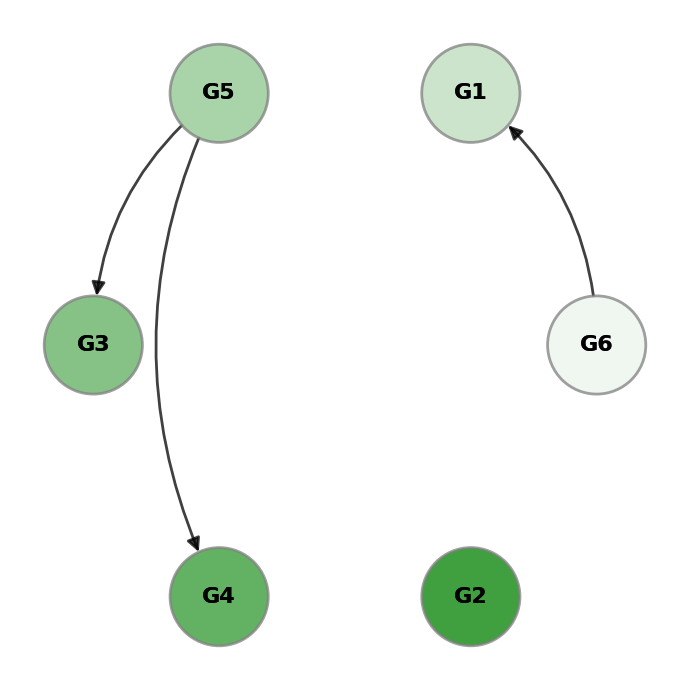

In [109]:
# --------------------------------------
#           Erdos-Renyi DAG
# --------------------------------------
np.random.seed(1)
nodes = 6
num_groups = 6
group_size = int(nodes/num_groups)
nonlinearity_factor = 0.25
interaction_density = 0.11
timesteps = 33

df, causalgraph, complete_graph = renyiDAG.generate_dag_and_time_series(nodes, interaction_density, nonlinearity_factor, timesteps, num_groups, group_size)

In [110]:
complete_graph

array([[1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 1, 1, 1, 0],
       [1, 0, 0, 0, 0, 1]])

<Axes: >

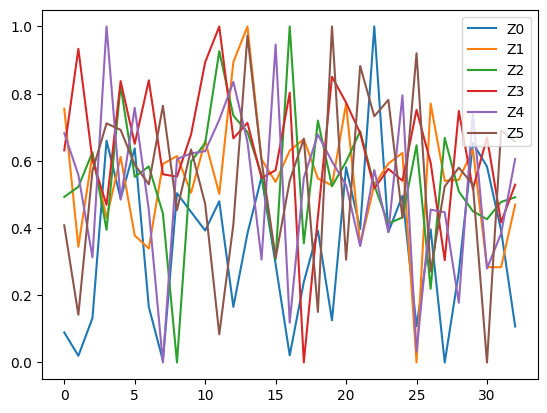

In [111]:
df.plot()

#### Generate Training Dataset

In [ ]:
original_data = []
dim, columns = len(df.columns), df.columns
for col in df:
    original_data.append(df[col])

original_data = np.array(original_data)
# training set
train_ds = ListDataset(
    [
        {'start': "01/03/2015 00:00:00",
         'target': original_data[:, 0: training_length].tolist()
         }
    ],
    freq=freq,
    one_dim_target=False
)

#### DeepAR Estimator

In [ ]:
# create estimator
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=prediction_length,
    freq=freq,
    num_layers=num_layers,
    num_cells=num_cells,
    dropout_rate=dropout_rate,
    trainer=Trainer(
        ctx="cpu",
        epochs=epochs,
        hybridize=False,
        batch_size=32
    ),
    distr_output=MultivariateGaussianOutput(dim=dim)
)

### Load/Train Model

In [ ]:
path = pars.get('model_path')
model_path = pathlib.Path(path + model_name)
# model_path = "../models/trained_model_georegime_cli9.sav"
# model_path = "../models/trained_model_syn22Sep.sav"
# model_path = "../models/trained_model_river16Jun.sav"

filename = pathlib.Path(model_path)
print(f'Model: {filename}')
if not filename.exists():
    print('Training DeepAR model....')
    predictor = estimator.train(train_ds)
    # save the model to disk
    pickle.dump(predictor, open(filename, 'wb'))

#### Generate Knockoffs

In [ ]:
data_actual = np.array(original_data[:, :]).transpose()
n = len(original_data[:, 0])
obj = Knockoffs()
pars.update({'length': n, 'dim': dim, 'col': columns})
knockoffs = obj.Generate_Knockoffs(data_actual, pars)

#### Esimate Causal Links

In [ ]:
# Function for estimating causal impact among variables
group_size_list = [value[0] for value in pars['groups_size'].values()]
ground_truth = gcdmi.get_ground_truth(causalgraph, group_size_list)
metrics, predicted_graph = groupCause(original_data, knockoffs, model_path, pars, ground_truth, False)
metrics

#### Computation Time

In [ ]:
# # Calculate difference
# elapsed_time = end_time - start_time
# # Print elapsed time
# print("Computation time: ", round(elapsed_time/60), "mins")